## Landcover classification with Keras DenseNet201 on EuroSAT data

# Table of Contents

1. [Context](#context)  
2. [Importations](#importations)  
3. [Informations](#informations)
4. [Set parameters](#set_parameters)
5. [Data exploration](#data_exploration)  
    5.1 [Numpy array](#numpy_array)  
    5.2 [Pictures](#pictures)  
6. [Modelisation](#modelisation)  
    6.1 [Learning](#learning)    
    6.2 [Learning curves](#learning_curves)  
    6.3 [Results](#results)  
    6.4 [Learning rate](#learning_rate)  
7. [Prediction](#prediction)  
    7.1 [Predict](#predict)    
    7.2 [Visualize](#visualize)  
    7.3 [Save](#save) 
8. [Conclusion](#conclusion)

# 1. Context <a id="context"></a>

<p style="text-align:center;">
    <img src="https://www.goodfreephotos.com/cache/other-landscapes/beautiful-landscape-panoramic-of-the-mountaintops.jpg" style="height:auto; width:100%"/>
</p>

<p style="text-align:justify;">The competition was organized on Codalab by CERFACS (Centre of basic and applied research specialized in modelling and numerical simulation), see more on : <a href="https://competitions.codalab.org/competitions/22820?secret_key=93fcb262-a531-431f-828d-dbb2111428ab">Codalab</a>. This notebook show the the winning solution over 19 participants <b>(Public : 0.98686 and Private : 0.98714 on accuracy)</b>. This competition and the data (EuroSAT) associated are inspired from this paper : <a href="https://arxiv.org/abs/1709.00029">https://arxiv.org/abs/1709.00029</a>.</p>

<p style="text-align:justify;"><b>This competition is about predicting the label of a satelite image among 10 possible ones.</b></p>

# 2. Importations <a id="importations"></a>

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Get version python/keras/tensorflow/sklearn
from platform import python_version
import sklearn
import keras
import tensorflow as tf

# Folder manipulation
import os

# Garbage collector
import gc

# Linear algebra and data processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Model evaluation
from sklearn.metrics import mean_absolute_error

# Visualisation of picture and graph
import matplotlib.pyplot as plt
import seaborn as sns

# Keras importation
from keras.applications import DenseNet201
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Dense
from keras.regularizers import l1_l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

Using TensorFlow backend.


# 3. Informations <a id="informations"></a>

In [2]:
print(os.listdir("../input"))
print("Keras version : " + keras.__version__)
print("Tensorflow version : " + tf.__version__)
print("Python version : " + python_version())
print("Sklearn version : " + sklearn.__version__)

['y_train.npy', 'X_test.npy', 'X_train.npy']
Keras version : 2.2.4
Tensorflow version : 1.13.1
Python version : 3.6.6
Sklearn version : 0.20.3


# 4. Set parameters <a id="set_parameters"></a>

In [3]:
MAIN_DIR = "../input/"
IMG_ROWS = 64
IMG_COLS = 64
CHANNELS = 3
IMG_SHAPE = (IMG_ROWS, IMG_COLS, CHANNELS)
LABELS = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 
        'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 
        'Residential', 'River', 'SeaLake']

# Set graph font size
sns.set(font_scale=1.3)

# 5. Data exploration <a id="data_exploration"></a>

## 5.1 Numpy array <a id="numpy_array"></a>

In [4]:
def load_data():
    X_total_train = np.load(MAIN_DIR + "X_train.npy")
    X_train = X_total_train[:, :, :, :CHANNELS].copy()

    # Free memory
    del X_total_train
    gc.collect()
    
    y_total_train = np.load(MAIN_DIR + "y_train.npy")
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_total_train)

    # Free memory
    del y_total_train
    gc.collect()

    # One-hot encoding y_train
    y_train = to_categorical(y_train)

    # Free memory
    gc.collect()
    
    return X_train, y_train, encoder

In [5]:
X_train, y_train, encoder = load_data()
print(f"X shape : {X_train.shape}")
print(f"y shape : {y_train.shape}")

X shape : (20000, 64, 64, 3)
y shape : (20000, 10)


## 5.2 Pictures <a id="pictures"></a>

In [6]:
def plot_pictures(X, y, nb_rows=6, nb_cols=6, figsize=(14, 14)):
    # Set up the grid
    fig, ax = plt.subplots(nb_rows, nb_cols, figsize=figsize, gridspec_kw=None)
    fig.subplots_adjust(wspace=0.4, hspace=0.4)

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            index = np.random.randint(0, X.shape[0])
    
            # Hide grid
            ax[i, j].grid(False)
            ax[i, j].axis('off')
            
            # Plot picture on grid
            ax[i, j].imshow(X[index].astype(np.int))
            ax[i, j].set_title(f"{LABELS[np.where(y[index] == 1)[0][0]]}")

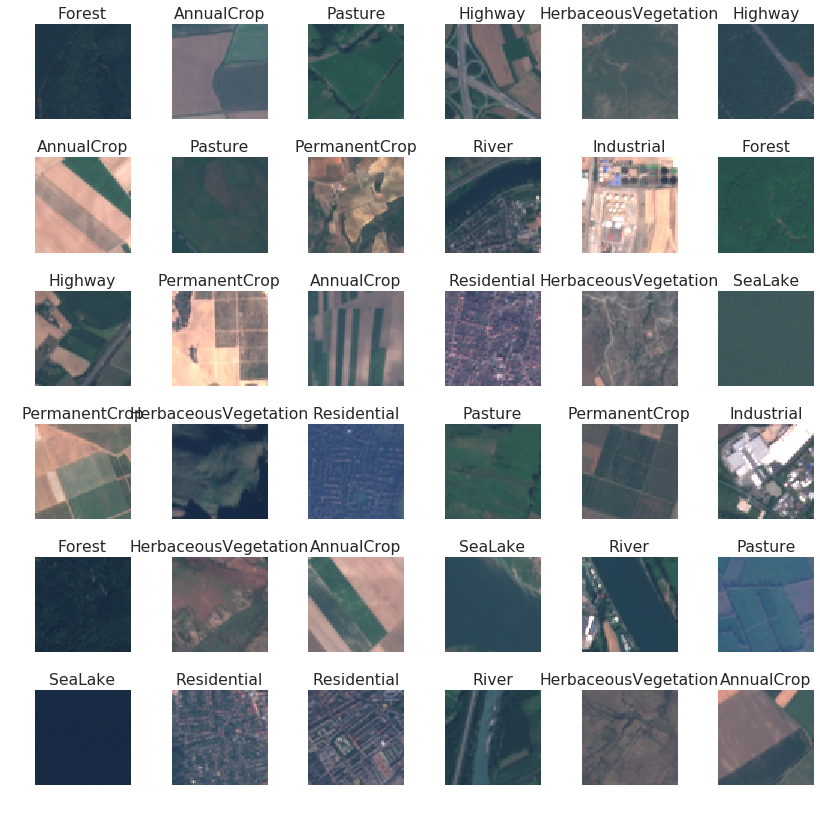

In [7]:
plot_pictures(X_train, y_train)

# 6. Modelisation <a id="modelisation"></a>

## 6.1 Learning <a id="learning"></a>

In [8]:
def load_gen(X, y):
    gen = ImageDataGenerator(
            validation_split=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest')

    gen_train = gen.flow(X, y,
                          batch_size=32, 
                          shuffle=True,
                          subset='training')

    gen_val = gen.flow(X, y,
                         batch_size=32, 
                         shuffle=True, 
                         subset='validation')
    
    return gen_train, gen_val

In [9]:
def build_model():
    model = Sequential()
    
    model.add(DenseNet201(input_shape=IMG_SHAPE, include_top=False, pooling='max'))
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu', kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])
    
    model.summary()
    
    return model

In [10]:
def train_model(gen_train, gen_val):
    model = build_model()

    cbs = [ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0),
           EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=1, mode='auto')]

    history = model.fit_generator(gen_train, 
                        steps_per_epoch=(gen_train.n//gen_train.batch_size), 
                        epochs=200, 
                        validation_data=gen_val, 
                        validation_steps=len(gen_val), 
                        shuffle=True, 
                        callbacks=cbs, 
                        verbose=1)
    return model, history

In [11]:
gc.collect()
gen_train, gen_val = load_gen(X_train, y_train)
model, history = train_model(gen_train, gen_val)

Instructions for updating:
Colocations handled automatically by placer.
74842112/74836368 [==============================] - 8s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              3934208   
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_3 (Batch (None, 2048)              8192      
_____

## 6.2 Learning curves <a id="learning_curves"></a>

In [12]:
def plot_loss(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot train/val accuracy
    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].legend(['Train', 'Test'], loc='lower right')
    ax[0].set_ylim(0, 1.05)
    
    # Plot train/val loss
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(['Train', 'Test'], loc='upper right')

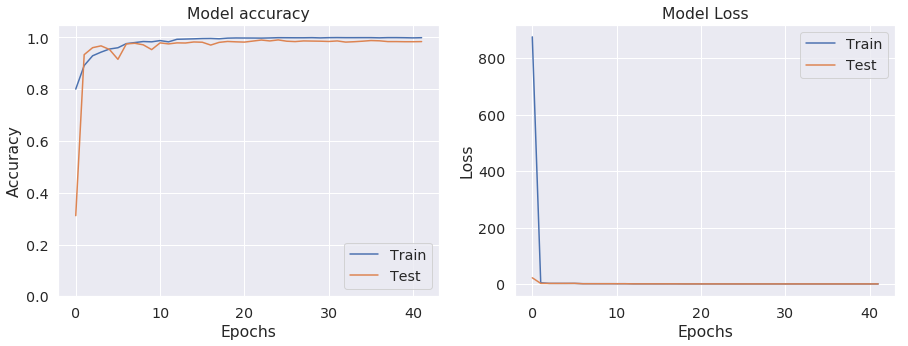

In [13]:
plot_loss(history)

## 6.3 Results <a id="results"></a>

In [14]:
def print_results(history):
    print("ACCURACY :")
    print(f"Training accuracy : {history.history['acc'][-1]}")
    print(f"Validation accuracy : {history.history['val_acc'][-1]}")
    
    print("\nLOSS :")
    print(f"Training categorical crossentropy loss : {history.history['loss'][-1]}")
    print(f"Validation categorical crossentropy loss : {history.history['val_loss'][-1]}")

In [15]:
print_results(history)

ACCURACY :
Training accuracy : 0.999053873552983
Validation accuracy : 0.984

LOSS :
Training categorical crossentropy loss : 0.2181865835391509
Validation categorical crossentropy loss : 0.26171418237686156


## 6.4 Learning rate <a id="learning_rate"></a>

In [16]:
def plot_lr(history):
    fig, ax = plt.subplots(figsize=(7, 5))
    
    # Plot learning rate
    ax.plot(history.history['lr'])
    ax.set_title('Learning rate evolution')
    ax.set_ylabel('Learning rate value')
    ax.set_xlabel('Epochs')
    ax.legend(['Train'], loc='upper right')

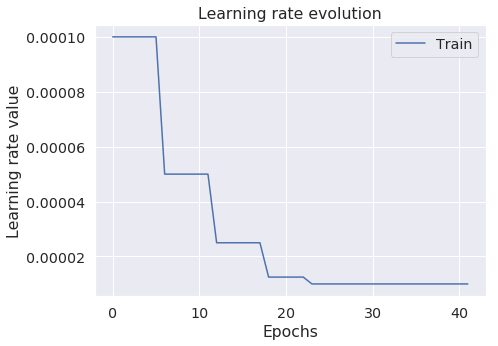

In [17]:
plot_lr(history)

# 7. Prediction <a id="prediction"></a>

## 7.1 Predict <a id="predict"></a>

In [18]:
def load_data_test():
    X_total_test = np.load(MAIN_DIR + "X_test.npy")
    X_test = X_total_test[:, :, :, :CHANNELS].copy()

    # Free memory
    del X_total_test
    gc.collect()
    
    return X_test

In [19]:
X_test = load_data_test()

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

## 7.2 Visualize <a id="visualize"></a>

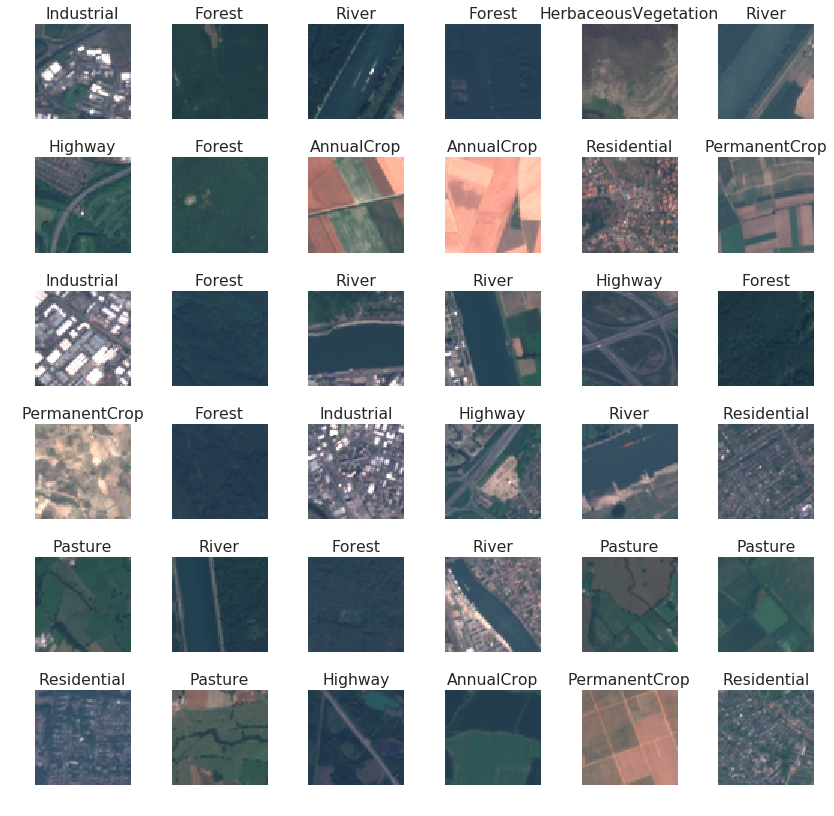

In [20]:
plot_pictures(X_test, to_categorical(y_pred))

## 7.3 Save <a id="save"></a>

In [21]:
def save_model(model):
    # Serialize model to JSON
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    
    # Serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to disk")

In [22]:
def save_pred(y_pred):
    y_pred = encoder.inverse_transform(y_pred)
    np.save("label_test.predict", y_pred)
    print("Save prediction")
    #!mv label_test.predict.npy label_test.predict
    #!zip -r submission.zip label_test.predict

In [23]:
save_pred(y_pred)
save_model(model)

Save prediction
Saved model to disk


# 8. Conclusion <a id="conclusion"></a>

<p style="text-align:justify;">Densenet201 seems to have better performance than GoogleLeNet or ResNet50 used in the paper. However it would be interesting to try bigger network (DenseNet269) or to use an other network architecture which perform better than DenseNet like ResNeXt, Xception, ...etc (see : <a href="https://keras.io/applications/"> Keras Applications</a>) for example. Furthemore, I think it would be also a really interesting idea to try NAS (Network Archicture Search) in order to find the best architecture for tackling this problem.</p>